# Qdrant & Image Data

![crab](../images/crabmera.png)

In this tutorial, you will learn how use semantic search for accurate skin cancer image comparison usign Qdrant and the 
Hugging Face's `transformers` and `datasets` libraries.

## 1. Overview

This tutorial aims to provide an in-depth walkthrough of how to employ semantic search techniques with image data. In particular, 
we'll go over an example on how to assist doctors in comparing rare or challenging images of skin cancer with pre-labeled 
images categorized with different diseases. With the power of semantic search, medical professionals could enhance 
their diagnostic capabilities and make more accurate decisions regarding skin cancer diagnosis. That said, you can swap the 
dataset used in this tutorial with your own and follow along with minimal adjustments to the code. 

The dataset used can be found in the [Hugging Face Hub](https://huggingface.co/datasets/marmal88/skin_cancer) and you don't 
need to take any additional step to download it other than to run the code below.

Here is a short description of each of the variables available.
- `image` - PIL objct of size 600x450
- `image_id` - unique id for the image
- `lesion_id` - unique id for the type of lesion on the skin of the patient
- `dx` - diagnosis given to the patient (e.g., melanocytic_Nevi, melanoma, benign_keratosis-like_lesions, basal_cell_carcinoma, 
actinic_keratoses, vascular_lesions, dermatofibroma)
- `dx_type` - type of diagnosis (e.g., histo, follow_up, consensus, confocal)
- `age` - the age of the patients from 5 to 86 (some values are missing)
- `sex` - the gender of the patient (female, male, and unknown)
- `localization` - location of the spot in the body (e.g., 'lower extremity', 'upper extremity', 'neck', 'face', 'back', 
'chest', 'ear', 'abdomen', 'scalp', 'hand', 'trunk', 'unknown', 'foot', 'genital', 'acral')

By the end of the tutorial, you will be able to extract embeddings from images using transformers and conduct image-to-image semantic search with Qdrant.

## 2. Set Up

Before you run any line of code, please make sure you have 
1. downloaded the data
2. created a virtual environment (if not in Google Colab)
3. installed the packages below
4. started a container with Qdrant

```bash
# with conda or mamba if you have it installed
mamba env create -n my_env python=3.10
mamba activate my_env

# or with virtualenv
python -m venv venv
source venv/bin/activate

# install packages
pip install qdrant-client transformers datasets torch numpy
```

The open source version of Qdrant is available as a docker image and it can be pulled and run from any machine with docker 
installed. If you don't have Docker installed in your PC you can follow the instructions in the official documentation 
[here](https://docs.docker.com/get-docker/). After that, open your terminal start by downloading the image with the following command.

```sh
docker pull qdrant/qdrant
```

Next, initialize Qdrant with the following command, and you should be good to go.

```sh
docker run -p 6333:6333 \
    -v $(pwd)/qdrant_storage:/qdrant/storage \
    qdrant/qdrant
```

Verify that you are ready to go by importing the following libraries and connecting to Qdrant via its Python client.

In [3]:
from transformers import ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset
import numpy as np
import torch

In [2]:
client = QdrantClient(host="localhost", port=6333)

In [18]:
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE)
)

True

## 3. Image Embeddings

In computer vision systems, vector databases are used to store image features. Image features are vector representations 
of images that capture their visual content, and they are used to improve the performance of computer vision tasks such 
as object detection, image classification, and image retrieval.

To extract these useful feature representation from our images, we'll use vision transformers (ViT). ViTs are advanced 
algorithms that enable computers to "see" and understand visual information in a similar fashion to how humans do. They 
use a transformer architecture to process images and extract meaningful features from images.

To understand how ViTs work, imagine you have a large jigsaw puzzle with many different pieces. To solve the puzzle, 
you would typically look at the individual pieces, their shapes, and how they fit together to form the full picture. ViTs 
work in a similar way, meaning, instead of looking at the entire image at once, vision transformers break it down 
into smaller parts called "patches." Each of these patches is like one piece of the puzzle that captures a specific portion 
of the image, and these pieces are then analyzed and processed by the ViTs.

By analyzing these patches, the ViTs identify important patterns such as edges, colors, and textures, and combines them 
to form a coherent understanding of a given image.

That said, let's get started using transformers to extract features from our images.

We'll start by reading in the data and examining one sample.

In [4]:
dataset = load_dataset("marmal88/skin_cancer", split='train')
dataset

Found cached dataset parquet (/home/ramonperez/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'image_id', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization'],
    num_rows: 9577
})

In [5]:
dataset[8500]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0025927',
 'lesion_id': 'HAM_0002557',
 'dx': 'melanoma',
 'dx_type': 'histo',
 'age': 50.0,
 'sex': 'female',
 'localization': 'upper extremity'}

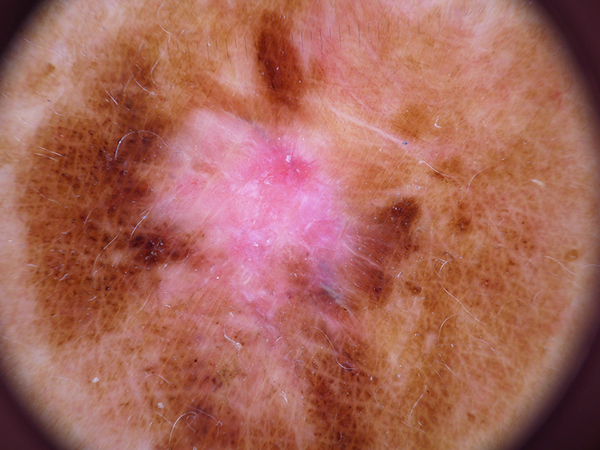

In [6]:
image = dataset[8500]["image"]
image

The image at index 8500, as shown above, is an instance of melanoma, which is a type of skin cancer that starts 
in the cells called melanocytes. These are responsible for producing a pigment called melanin that gives color 
to our skin, hair, and eyes. When melanocytes become damaged or mutate, they can start growing and dividing rapidly, 
forming a cancerous growth known as melanoma. Melanoma often appears as an unusual or changing mole, spot, or 
growth on the skin, and it can be caused by excessive exposure to ultraviolet (UV) radiation from the sun or 
tanning beds, as well as genetic factors. If detected early, melanoma can usually be treated successfully, 
but if left untreated, it can spread to other parts of the body and become more difficult to treat.

Because Melanoma can often be difficult to detect, and we want to empower doctors with the ability to compare 
and contrast cases that are difficult to classify without invasive procedures (i.e., by taking a sample of the 
skin of the patient), we will create for them a system that allows them to compare images taken from patients 
with the vectors from labeled ones inside Qdrant.

In order to search through the images and provide the most similar ones to the doctors, we'll need to download 
a pre-trained model that will help us extract the embedding layer from our dataset. We'll do this using the 
transformers library and Facebook's DINO model.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

/home/ramonperez/anaconda/envs/qdrant101/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's process the instance of melanoma we selected earlier.

In [8]:
inputs = processor(images=image, return_tensors="pt")
inputs['pixel_values'].shape, inputs

(torch.Size([1, 3, 224, 224]),
 {'pixel_values': tensor([[[[-1.3987, -1.4329, -1.4500,  ..., -1.0904, -1.1075, -1.0904],
           [-1.4158, -1.4329, -1.4500,  ..., -1.0904, -1.1075, -1.1075],
           [-1.4329, -1.4500, -1.4500,  ..., -1.1247, -1.1075, -1.1075],
           ...,
           [-1.1075, -1.1075, -1.0904,  ..., -1.4843, -1.5014, -1.5357],
           [-1.1075, -1.1075, -1.0904,  ..., -1.4843, -1.5185, -1.5528],
           [-1.1247, -1.1247, -1.0904,  ..., -1.4843, -1.5357, -1.5528]],
 
          [[-1.7381, -1.7381, -1.7556,  ..., -1.5980, -1.6155, -1.6331],
           [-1.7381, -1.7381, -1.7556,  ..., -1.6155, -1.6331, -1.6506],
           [-1.7381, -1.7381, -1.7556,  ..., -1.5980, -1.6155, -1.6155],
           ...,
           [-1.5630, -1.5630, -1.5630,  ..., -1.7731, -1.7906, -1.7906],
           [-1.5630, -1.5630, -1.5630,  ..., -1.7906, -1.7906, -1.8081],
           [-1.5805, -1.5805, -1.5630,  ..., -1.7906, -1.8081, -1.8081]],
 
          [[-1.3513, -1.3687, -1.3861,

In [9]:
one_embedding = model(**inputs).last_hidden_state
one_embedding.shape, one_embedding[0, 0, :20]

(torch.Size([1, 197, 384]),
 tensor([ 3.0854,  4.9196, -1.1094,  3.3949, -0.8139,  4.8751,  4.4032, -0.6903,
          5.5181,  8.6680,  1.6411,  5.6704,  2.2703, -1.3895, -1.8102, -1.4204,
          8.9997,  8.5076,  5.1398, -7.1862], grad_fn=<SliceBackward0>))

As you can see, what we get back from our preprocessing function is a multi-dimensional tensor represented 
as [`batch_size`, `channels`, `rows`, `columns`]. The `batch_size` is the amount of samples passed through our 
feature extractor and the channels represent the red, green, and blue hues of the image. Lastly, the rows and 
columns, which can also be thought of as dimensions, represent the width and height of the image. This 
4-dimensional representation is the input our model expects. In return, we get back a tensor 
of [`batch_size`, `patches`, `dimensions`], and what's left for us to do is to choose a pooling method 
for our embedding as it is not feasible to use 197 embedding vectors when one would suffice. For the final step,
we'll use mean pooling.

In [10]:
one_embedding.mean(dim=1).shape

torch.Size([1, 384])

Let's create a function with the process we just walked through above and map it to our dataset to get an 
embedding vector for each image.

In [11]:
def get_embeddings(batch):
    inputs = processor(images=batch['image'], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    batch['embeddings'] = outputs
    return batch

In [12]:
dataset = dataset.map(get_embeddings, batched=True, batch_size=16)

Map:   0%|          | 0/9577 [00:00<?, ? examples/s]

In [ ]:
dataset

As you can see, we now have an embedding for each of the images in our dataset. 

We'll now save the vector of embeddings as a NumPy array so the we don't have to run it again later if 
take a break or accidentally close down the tutorial. Then what we want to do is to create a payload 
with the metadata about each of our images. We can accomplish this by converting the rest of the 
columns we didn't use into a JSON object for each sample.

In [13]:
np.save("vectors", np.array(dataset['embeddings']), allow_pickle=False)

In [38]:
payload = dataset.select_columns([
    "image_id", 'dx', 'dx_type', 'age', 'sex', 'localization'
]).to_pandas().fillna({"age": 0}).to_dict(orient="records")

payload[:3]

[{'image_id': 'ISIC_0024329',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'female',
  'localization': 'lower extremity'},
 {'image_id': 'ISIC_0024372',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 70.0,
  'sex': 'male',
  'localization': 'lower extremity'},
 {'image_id': 'ISIC_0024418',
  'dx': 'actinic_keratoses',
  'dx_type': 'histo',
  'age': 75.0,
  'sex': 'female',
  'localization': 'lower extremity'}]

Note that in the cell above we use `.fillna({"age": 0})`, that is because there are several missing values in the `age` column. Because 
we don't want to assume the age of a patient, we'll leave this number as 0. It is also important to note that, at the time of writing, 
Qdrant will not take in NumPy `NaN`s but rather regular `None` Python values for anything that might be missing in our dataset.

To make sure each image has an explicit id inside of our Qdrant collection from earlier, we'll create a new column with a range of 
numbers equivalent to the rows in our dataset. In addition, we'll load the embeddings we just saved.

In [16]:
ids = list(range(dataset.num_rows))
embeddings = np.load("vectors.npy").tolist()

Now we are now ready to upsert the combination of ids, vectors and payload to our collection. We'll do this in batches of 1000.

In [39]:
batch_size = 1000

for i in range(0, dataset.num_rows, batch_size):

    low_idx = min(i+batch_size, dataset.num_rows)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )

In [40]:
client.count(
    collection_name=my_collection, 
    exact=True,
)

CountResult(count=9577)

To make sure our collections has been indeed created, we can scroll through our vectors with the `client.scroll()` method.

In [36]:
client.scroll(
    collection_name=my_collection,
    limit=5
)

([Record(id=0, payload={'age': 75.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'localization': 'lower extremity', 'sex': 'female'}, vector=None),
  Record(id=1, payload={'age': 70.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'localization': 'lower extremity', 'sex': 'male'}, vector=None),
  Record(id=2, payload={'age': 75.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'localization': 'lower extremity', 'sex': 'female'}, vector=None),
  Record(id=3, payload={'age': 50.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'localization': 'upper extremity', 'sex': 'male'}, vector=None),
  Record(id=4, payload={'age': 50.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'localization': 'upper extremity', 'sex': 'male'}, vector=None)],
 5)

## 4. Semantic Search

Semantic search, in the context of vector databases and image retrieval, refers to a method of searching for information or images 
based on their meaning or content rather than just using keywords. Imagine you're looking for a specific picture of a skin disease, but you 
don't know the file name or where it is stored. With semantic search, you can describe what you're looking for using words like 
"red rashes with blisters," or you can upload an image that will get processed into an embedding vector, and the system will analyze 
the content of the images to find matches that closely match your description or input image.

Semantic search enables a more intuitive and efficient way of searching for images, making it easier to find what you're 
looking for, even if you can't remember specific details or tags.

With Qdrant, we can get searching with the `client.search()` method.

In [25]:
client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    limit=10
)

[ScoredPoint(id=8500, version=8, score=1.0, payload={'age': 50.0, 'dx': 'melanoma', 'dx_type': 'histo', 'localization': 'upper extremity', 'sex': 'female'}, vector=None),
 ScoredPoint(id=9205, version=9, score=0.92966413, payload={'age': 55.0, 'dx': 'melanoma', 'dx_type': 'histo', 'localization': 'back', 'sex': 'female'}, vector=None),
 ScoredPoint(id=9420, version=9, score=0.9249702, payload={'age': 35.0, 'dx': 'melanoma', 'dx_type': 'histo', 'localization': 'abdomen', 'sex': 'male'}, vector=None),
 ScoredPoint(id=9241, version=9, score=0.92033136, payload={'age': 55.0, 'dx': 'melanoma', 'dx_type': 'histo', 'localization': 'back', 'sex': 'male'}, vector=None),
 ScoredPoint(id=968, version=0, score=0.9159926, payload={'age': 80.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'consensus', 'localization': 'face', 'sex': 'female'}, vector=None),
 ScoredPoint(id=8510, version=8, score=0.9090265, payload={'age': 55.0, 'dx': 'melanoma', 'dx_type': 'histo', 'localization': 'upper extremi

As you can see in the cell above, we used the melanoma image from before and we got back other images with Melanoma. But 
what if our doctors want to look for images from patients as demographically similar to one they are evaluating. For this,
we can take advantage of Qdrant's Filters.

In [35]:
female_older_than_55 = models.Filter(
    must=[
        models.FieldCondition(key="sex", match=models.MatchValue(value="female")),
    ],
    should=[
        models.FieldCondition(key="age", range=models.Range(lt=None, gt=None, gte=55.0, lte=None))
    ]
)

In [42]:
results = client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    query_filter=female_older_than_55,
    limit=10
)
results

[ScoredPoint(id=9205, version=19, score=0.92966413, payload={'age': 55.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_id': 'ISIC_0033269', 'localization': 'back', 'sex': 'female'}, vector=None),
 ScoredPoint(id=968, version=10, score=0.9159926, payload={'age': 80.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'consensus', 'image_id': 'ISIC_0025851', 'localization': 'face', 'sex': 'female'}, vector=None),
 ScoredPoint(id=9009, version=19, score=0.90100384, payload={'age': 75.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_id': 'ISIC_0032244', 'localization': 'face', 'sex': 'female'}, vector=None),
 ScoredPoint(id=180, version=10, score=0.896978, payload={'age': 80.0, 'dx': 'actinic_keratoses', 'dx_type': 'histo', 'image_id': 'ISIC_0029417', 'localization': 'neck', 'sex': 'female'}, vector=None),
 ScoredPoint(id=1377, version=11, score=0.89676714, payload={'age': 85.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'histo', 'image_id': 'ISIC_0029613', 'localization': 'chest', '

Notice on the payload above how we were able to match the doctors' criteria effortlessly. When providing 
them with metric-based similarity search, it is also important to give them the score of the result so that 
they have an idea as to how useful the images might be.

Let's evaluate visually the images we just got.

In [47]:
def see_images(results, top_k=5):
    for i in range(top_k):
        image_id = results[i].payload['image_id']
        score    = results[i].score
        dx       = results[i].payload['dx']
        gender   = results[i].payload['sex']
        age      = results[i].payload['age']
        image = dataset.filter(
            lambda x: x == image_id, input_columns="image_id"
        ).select_columns("image")[0]['image']

        print(f"Result #{i+1}: {gender} age {age} was diagnosed with {dx}")
        print(f"This image score was {score}")
        display(image)
        print("-" * 50)
        print()

Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-18b33cf635a9cb3a.arrow


Result #1: female age 55.0 was diagnosed with melanoma
This image score was 0.92966413


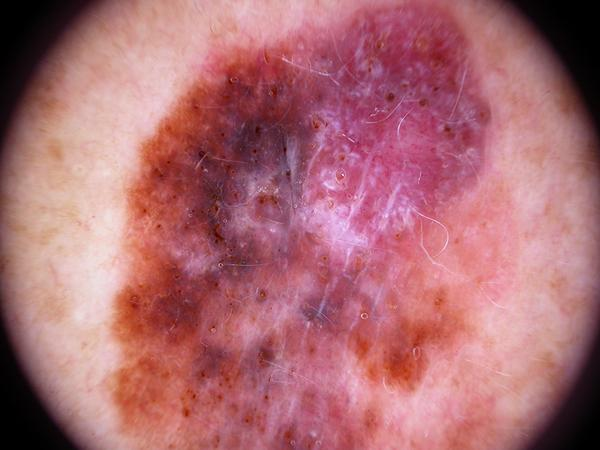

Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-abb1982dc3188052.arrow


--------------------------------------------------

Result #2: female age 80.0 was diagnosed with benign_keratosis-like_lesions
This image score was 0.9159926


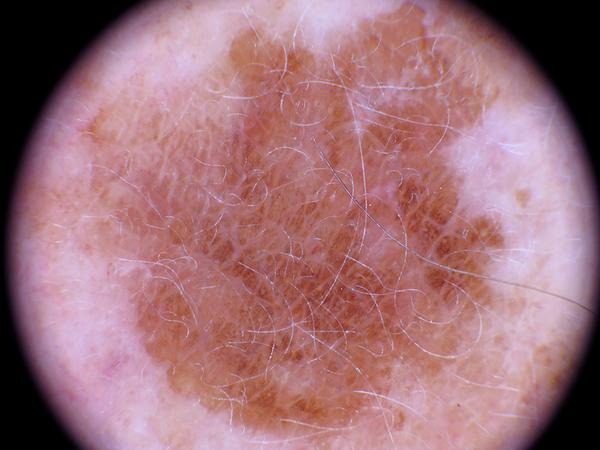

Loading cached processed dataset at /home/ramonperez/.cache/huggingface/datasets/marmal88___parquet/marmal88--skin_cancer-4d80d9330324f110/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-d797830760677930.arrow


--------------------------------------------------

Result #3: female age 75.0 was diagnosed with melanoma
This image score was 0.90100384


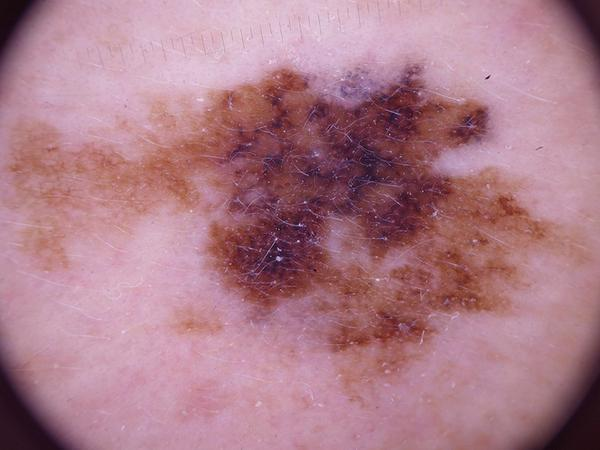

--------------------------------------------------



In [49]:
see_images(results, 3)

In critical applications where the stakes are high, it might be useful to provide doctors with a similarity 
threshold so that they can be more confident of the result they are seeing. Let's pick another image and see how to 
do this with Qdrant.

melanocytic_Nevi


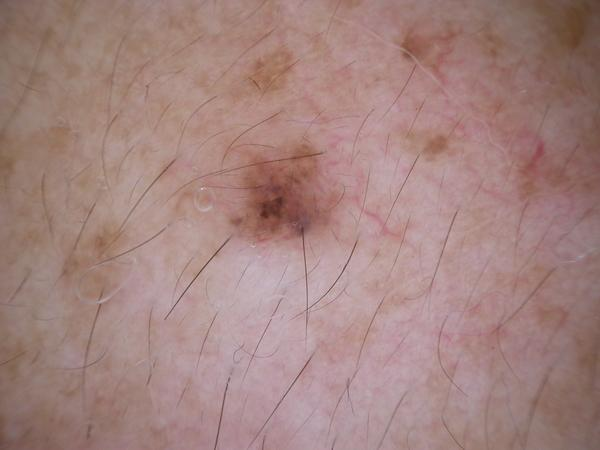

In [54]:
another_image = dataset[7777]
print(another_image['dx'])
display(another_image['image'])

In [57]:
results2 = client.search(
    collection_name=my_collection,
    query_vector=another_image['embeddings'],
    score_threshold=0.92,
    limit=20
)
results2[:7]

[ScoredPoint(id=7777, version=17, score=1.0, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0033244', 'localization': 'face', 'sex': 'male'}, vector=None),
 ScoredPoint(id=7388, version=17, score=0.96020913, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0032574', 'localization': 'face', 'sex': 'male'}, vector=None),
 ScoredPoint(id=6586, version=16, score=0.94182134, payload={'age': 55.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'consensus', 'image_id': 'ISIC_0031317', 'localization': 'neck', 'sex': 'male'}, vector=None),
 ScoredPoint(id=8920, version=18, score=0.94001937, payload={'age': 75.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_id': 'ISIC_0031118', 'localization': 'upper extremity', 'sex': 'male'}, vector=None),
 ScoredPoint(id=3825, version=13, score=0.9327799, payload={'age': 30.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0027137', 'localization': 'back', 'sex': 'female'}, vec

We can see that none of the results that came back have a cosine similarity score of less than 92%, and this 
exactly the behaviour we were expecting. Now, what if the dermatologist evaluating the results wanted to search 
only through specific ones because they remembered these were very similar spots to those of the current 
patient? The answer is that we could explicitly give the dermatologist a way to search images that match an id. 
Let's create range of ids from 5000 to 6000 in steps of 20, and have are query return only vectors in this range.

In [74]:
a_random_range = list(range(5000, 6000, 20))
client.search(
    collection_name=my_collection,
    query_vector=another_image['embeddings'],
    query_filter=models.Filter(must=[models.HasIdCondition(has_id=a_random_range)]),
    limit=10
)

[ScoredPoint(id=5940, version=15, score=0.8642086, payload={'age': 60.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'follow_up', 'image_id': 'ISIC_0030374', 'localization': 'abdomen', 'sex': 'male'}, vector=None),
 ScoredPoint(id=5180, version=15, score=0.85313225, payload={'age': 50.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'follow_up', 'image_id': 'ISIC_0029205', 'localization': 'back', 'sex': 'female'}, vector=None),
 ScoredPoint(id=5980, version=15, score=0.85215414, payload={'age': 40.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0030429', 'localization': 'scalp', 'sex': 'female'}, vector=None),
 ScoredPoint(id=5680, version=15, score=0.84486425, payload={'age': 40.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'follow_up', 'image_id': 'ISIC_0029981', 'localization': 'upper extremity', 'sex': 'female'}, vector=None),
 ScoredPoint(id=5840, version=15, score=0.8423323, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'follow_up', 'image_id': 'ISIC_0030221', 'localiza

What if the dermatologist wanted to exclude specific samples that may have been included twice, by accident, or 
as the product of synthetic data algorithm? We can follow the same process as above and swap the `must=` parameter 
for `must_not'` and you'll notice how our search results now don't include ids in the range we provided anymore. 

In [75]:
client.search(
    collection_name=my_collection,
    query_vector=another_image['embeddings'],
    query_filter=models.Filter(must_not=[models.HasIdCondition(has_id=a_random_range)]),
    limit=10
)

[ScoredPoint(id=7777, version=17, score=1.0, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0033244', 'localization': 'face', 'sex': 'male'}, vector=None),
 ScoredPoint(id=7388, version=17, score=0.96020913, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0032574', 'localization': 'face', 'sex': 'male'}, vector=None),
 ScoredPoint(id=6586, version=16, score=0.94182134, payload={'age': 55.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'consensus', 'image_id': 'ISIC_0031317', 'localization': 'neck', 'sex': 'male'}, vector=None),
 ScoredPoint(id=8920, version=18, score=0.94001937, payload={'age': 75.0, 'dx': 'melanoma', 'dx_type': 'histo', 'image_id': 'ISIC_0031118', 'localization': 'upper extremity', 'sex': 'male'}, vector=None),
 ScoredPoint(id=3825, version=13, score=0.9327799, payload={'age': 30.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'histo', 'image_id': 'ISIC_0027137', 'localization': 'back', 'sex': 'female'}, vec

If the reason doctors are searching for images in a vector database is because the need help in making a desicion, 
then they will certainly want to evaluate images **with** and **without** the decease. Let's evaluate another sample 
of melanoma and compare it to images similar to it but without cancer and that are not located on the face or the neck.

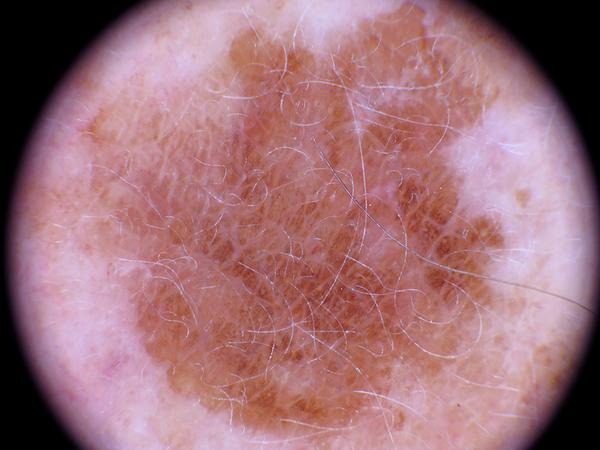

In [76]:
melo_sample_2 = dataset[968]
melo_sample_2['image']

In [79]:
not_cancer_not_face_or_neck = models.Filter(
    must=[models.FieldCondition(key="dx", match=models.MatchExcept(**{"except": ["melanoma", "actinic_keratoses"]}))],
    must_not=[models.FieldCondition(key="localization", match=models.MatchAny(any=["face", "neck"]))]
)

In [80]:
results3 = client.search(
    collection_name=my_collection,
    query_vector=melo_sample_2['embeddings'],
    query_filter=not_cancer_not_face_or_neck,
    limit=10
)
results3

[ScoredPoint(id=1504, version=11, score=0.92056465, payload={'age': 70.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'histo', 'image_id': 'ISIC_0031050', 'localization': 'lower extremity', 'sex': 'female'}, vector=None),
 ScoredPoint(id=4549, version=14, score=0.9064056, payload={'age': 40.0, 'dx': 'melanocytic_Nevi', 'dx_type': 'consensus', 'image_id': 'ISIC_0028252', 'localization': 'abdomen', 'sex': 'female'}, vector=None),
 ScoredPoint(id=1552, version=11, score=0.9024446, payload={'age': 70.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'histo', 'image_id': 'ISIC_0031522', 'localization': 'chest', 'sex': 'male'}, vector=None),
 ScoredPoint(id=1698, version=11, score=0.8992104, payload={'age': 70.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'histo', 'image_id': 'ISIC_0032978', 'localization': 'chest', 'sex': 'male'}, vector=None),
 ScoredPoint(id=1289, version=11, score=0.89824086, payload={'age': 70.0, 'dx': 'benign_keratosis-like_lesions', 'dx_type': 'histo',

Filter:   0%|          | 0/9577 [00:00<?, ? examples/s]

Result #1: female age 70.0 was diagnosed with benign_keratosis-like_lesions
This image score was 0.92056465


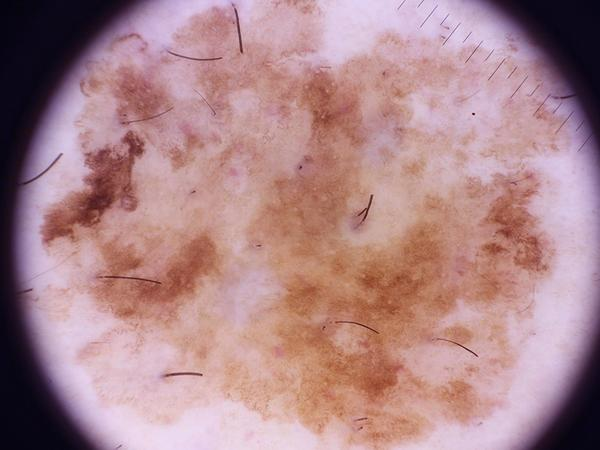

--------------------------------------------------



Filter:   0%|          | 0/9577 [00:00<?, ? examples/s]

Result #2: female age 40.0 was diagnosed with melanocytic_Nevi
This image score was 0.9064056


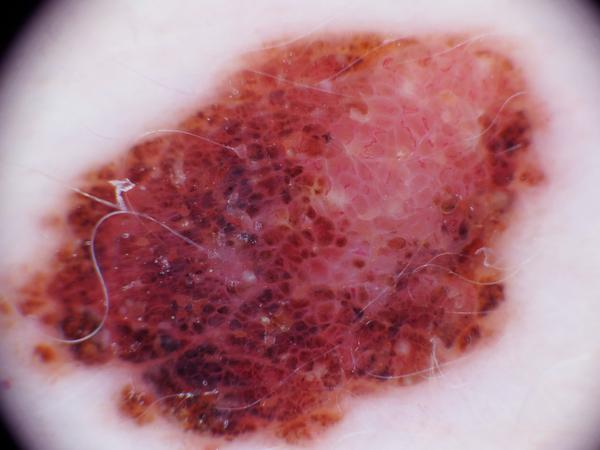

--------------------------------------------------



Filter:   0%|          | 0/9577 [00:00<?, ? examples/s]

Result #3: male age 70.0 was diagnosed with benign_keratosis-like_lesions
This image score was 0.9024446


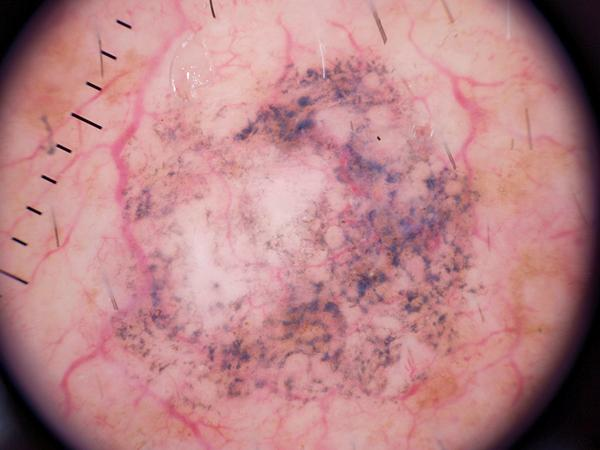

--------------------------------------------------



In [81]:
see_images(results3, 3)

As you can see from the images above, doctors can have a pretty tough job when it comes to diagnosing 
people. Some benign diseases like the ones above can often look like cancerous spot while in reality 
the patient is not at risk can avoid a potentially very costly and painful procedure.

Lastly, what if there were a team of doctors working evaluating different samples of skin cancer, 
each could have its own version of the tool or we could batch those queries and leave the logic 
on how to serve the results to the developers at the hospital. Let's write two different queries and 
collect all of the results at once.

In [83]:
filter_1 = models.Filter(must=[
    models.FieldCondition(key="localization", match=models.MatchValue(value="chest"))
])

In [82]:
filter_2 = models.Filter(must_not=[
    models.FieldCondition(key="dx", match=models.MatchValue(value="benign_keratosis-like_lesions"))
])

In [88]:
dataset[7700]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450>,
 'image_id': 'ISIC_0033109',
 'lesion_id': 'HAM_0002519',
 'dx': 'melanocytic_Nevi',
 'dx_type': 'histo',
 'age': 45.0,
 'sex': 'female',
 'localization': 'abdomen',
 'embeddings': [-1.3768508434295654,
  -3.1177451610565186,
  -1.8459553718566895,
  2.702944040298462,
  1.3643091917037964,
  -1.3680425882339478,
  -0.14273276925086975,
  -2.3411216735839844,
  -0.8024721145629883,
  0.9451342821121216,
  0.6847885847091675,
  -1.7337466478347778,
  4.089465618133545,
  0.13950523734092712,
  2.085069417953491,
  -0.4815092980861664,
  -2.129425287246704,
  -1.4365137815475464,
  -1.8181049823760986,
  0.02144727297127247,
  1.3777811527252197,
  0.5414249897003174,
  -3.24760103225708,
  1.628983736038208,
  0.2652471661567688,
  -0.3476469814777374,
  1.6326797008514404,
  0.7859706282615662,
  0.04935622960329056,
  0.3498598635196686,
  -0.9222443699836731,
  1.7748905420303345,
  2.159213066101074,
  0.1711

In [100]:
query_1 = models.SearchRequest(
    vector=dataset[700]['embeddings'],
    filter=filter_1,
    with_payload=models.PayloadSelectorExclude(
        exclude=["image_id", "dx_type"],
    ),
    limit=4
)

In [101]:
query_2 = models.SearchRequest(
    vector=dataset[7700]['embeddings'],
    filter=filter_2,
    with_payload=models.PayloadSelectorExclude(
        exclude=["image_id", "dx_type", "localization"],
    ),
    limit=7
)

In [102]:
client.search_batch(
    collection_name=my_collection,
    requests=[query_1, query_2]
)

[[ScoredPoint(id=6965, version=16, score=0.9660648, payload={'age': 55.0, 'dx': 'melanocytic_Nevi', 'localization': 'chest', 'sex': 'male'}, vector=None),
  ScoredPoint(id=486, version=10, score=0.9543208, payload={'age': 55.0, 'dx': 'basal_cell_carcinoma', 'localization': 'chest', 'sex': 'male'}, vector=None),
  ScoredPoint(id=7130, version=17, score=0.9542694, payload={'age': 55.0, 'dx': 'melanocytic_Nevi', 'localization': 'chest', 'sex': 'male'}, vector=None),
  ScoredPoint(id=4063, version=14, score=0.9509105, payload={'age': 75.0, 'dx': 'melanocytic_Nevi', 'localization': 'chest', 'sex': 'male'}, vector=None)],
 [ScoredPoint(id=7700, version=17, score=0.99999976, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'sex': 'female'}, vector=None),
  ScoredPoint(id=7726, version=17, score=0.96449125, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'sex': 'female'}, vector=None),
  ScoredPoint(id=7624, version=17, score=0.91722286, payload={'age': 45.0, 'dx': 'melanocytic_Nevi', 'sex': 'f

Excellent! Notice how we got back to lists of results that respect the criteria we've chosen to filter by and 
the payload we wanted to exclude from each.

That's it! In the next section we will create an app to showcase the usability of the search engine we've 
been learning about in this tutorial.

## 5. Putting It All Together

In [109]:
%%writefile image_search_app.py

from transformers import  ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
import streamlit as st
import torch

st.title("Skin Images Search Engine")
st.markdown("Upload images with different skin conditions and you'll get the most similar ones from our database of images.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)
client = QdrantClient("localhost", port=6333)

search_top_k = st.slider('How many search results do you want to retrieve?', 1, 40, 5)
image_file = st.file_uploader(label="📷 Skin Condition Image file 🔍")

if image_file:
    st.image(image_file)

    inputs = processor(images=image_file, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()

    st.markdown("## Semantic Search")
    results = client.search(collection_name="image_collection", query_vector=outputs[0], limit=search_top_k)
    
    for i in range(search_top_k):
        st.header(f"Decease: {results[i].payload['dx']}")
        st.subheader(f"Image ID: {results[i].payload['image_id']}")
        st.markdown(f"Location: {results[i].payload['localization']}")
        st.markdown(f"Gender: {results[i].payload['sex']}")
        st.markdown(f"Age: {results[i].payload['age']}")

Overwriting image_search_app.py


In [ ]:
!streamlit run image_search_app.py

## 5. Final Thoughts

We have covered quite a bit in this tutorial, and we've only scratched the surface of what we can 
do with vectors from images and Qdrant. Since we can understand there are a lot of moving parts when 
it comes to converting images into vectors or how to go beyond sematic search with Qdrant, here are 
tutorials you can go through to increase your knowledge on these topics.

- [Fine Tuning Similar Cars Search](https://qdrant.tech/articles/cars-recognition/)
- ...